In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn. preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

sns.set_style('darkgrid')

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_df = pd.read_csv('data/train.csv')

print(data_df.shape)
data_df.sample(4,random_state=1)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
258,259,60,RL,80.0,12435,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,231500
267,268,75,RL,60.0,8400,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,179500
288,289,20,RL,NaN,9819,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,122000
649,650,180,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2007,WD,Normal,84500


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
ohe_features = [
    "LotShape",
    "Street",
    "ExterCond",
    "OverallCond",
    "OverallQual",
    "Condition1",
    "Condition2",
    "Functional",
    "MSZoning",
    "FireplaceQu",
]

te_features = ["Neighborhood"]

num_features = [
    "BedroomAbvGr",
    "BsmtFinSF1",
    "BsmtFullBath",
    "EnclosedPorch",
    "GarageArea",
    "LotArea",
    "1stFlrSF",
    "2ndFlrSF",
    "TotalBsmtSF"
]

mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]
print(mixed_df.shape)

(1460, 20)


# Exploratory data analysis

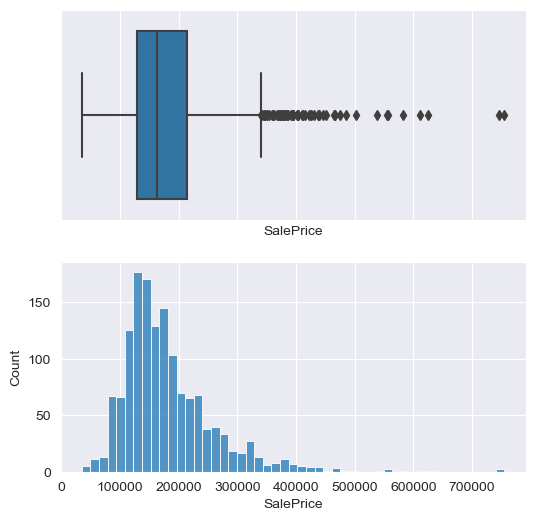

In [113]:
# Target distribution
fig,ax = plt.subplots(2,1,figsize=(6,6), sharex=True)

sns.boxplot(x=target, ax=ax[0]);
sns.histplot(x=target, ax=ax[1]);

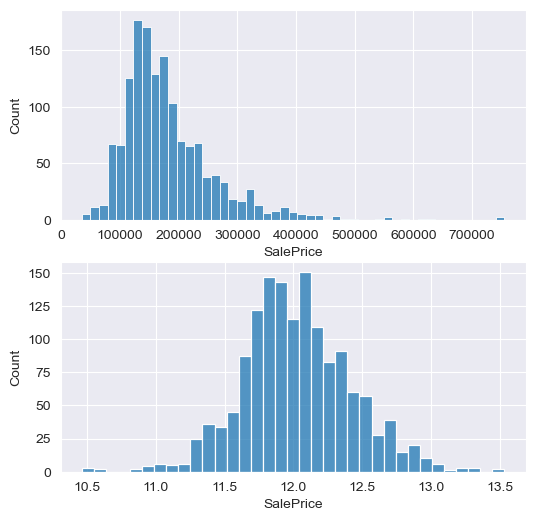

In [114]:
# Target distribution and log transfer
fig,ax = plt.subplots(2,1,figsize=(6,6))

sns.histplot(x=target, ax=ax[0]);
sns.histplot(x=np.log(target),ax=ax[1]);

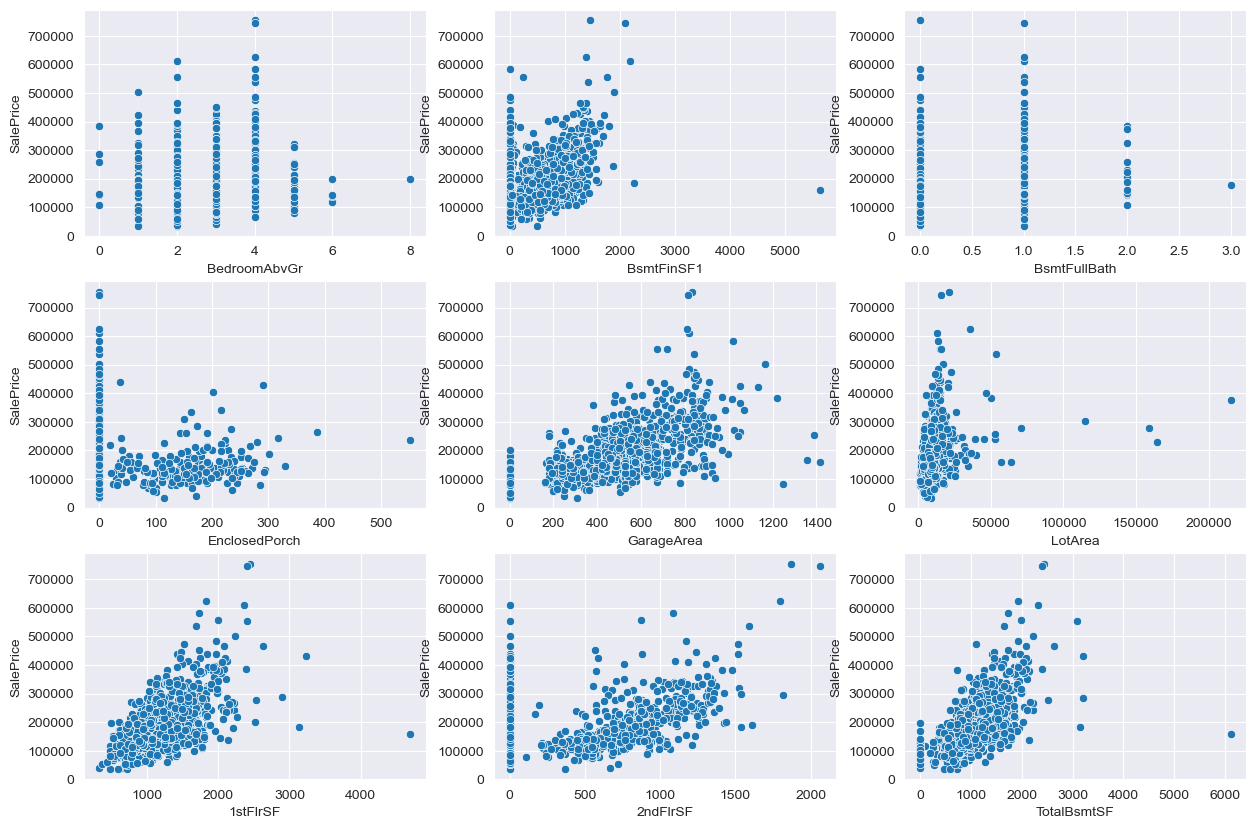

In [115]:
fig, ax = plt.subplots (3, 3, figsize=(15, 10))
for var, subplot in zip(num_features, ax.flatten( ) ):
    sns.scatterplot ( x=var, y=target, data=mixed_df, ax=subplot );

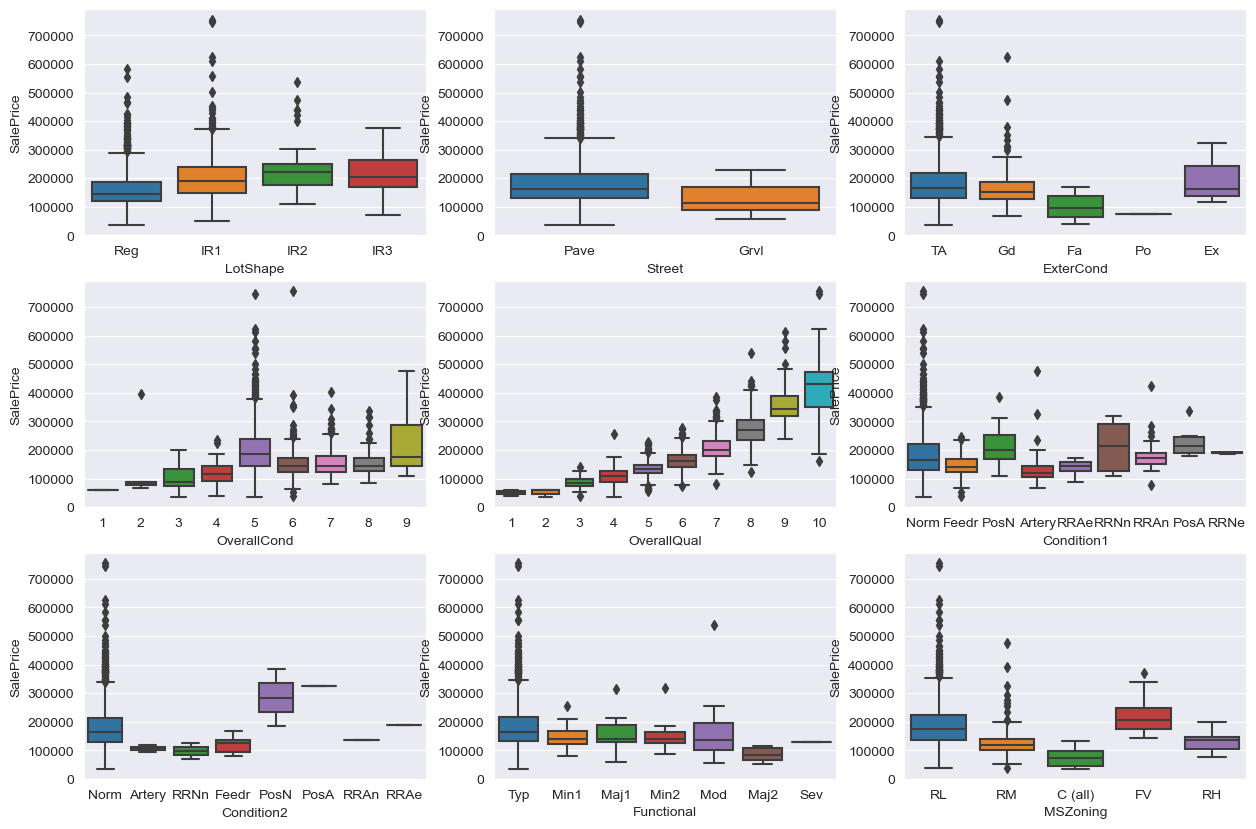

In [116]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
for var, subplot in zip(ohe_features, ax.flatten()):
    sns.boxplot(x=var, y=target, data=mixed_df, ax=subplot)

# Linear regression

In [117]:
dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, test_size=0.2, random_state=42)

preprocess = make_column_transformer ((StandardScaler( ), num_features),
                                      (OneHotEncoder(handle_unknown="ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown="value" ), te_features),)

pipe = make_pipeline(preprocess, LinearRegression( ))
scores = cross_val_score(pipe, dev_X, dev_y, cv=10, error_score="raise")
print (scores)
print (f'The mean score of this model is:{np.mean(scores):0.3f}')

[0.89254383 0.80561418 0.86780449 0.68047267 0.43948614 0.81754829
 0.82960742 0.84203075 0.8537854  0.85471703]
The mean score of this model is:0.788


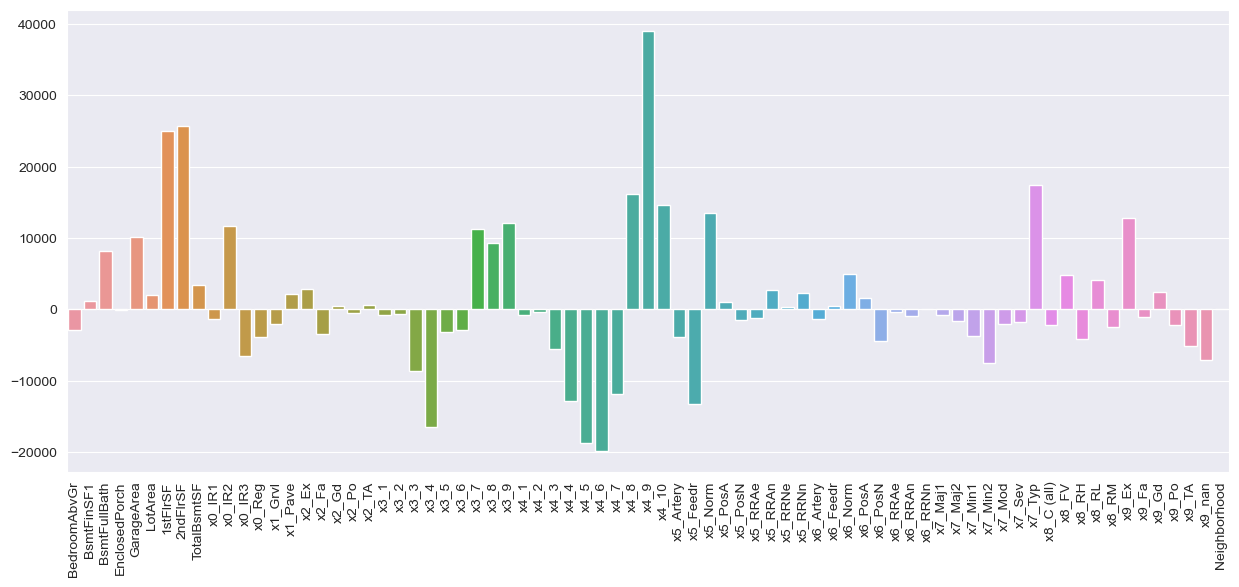

In [118]:
pipe.fit(dev_X, dev_y)
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
te_feature_names = preprocess.named_transformers_["targetencoder"].get_feature_names()
feature_names = num_features + ohe_feature_names + te_feature_names
coefs = pipe[-1].coef_
fig,ax = plt.subplots(1,1,figsize=(15,6))
ax = sns.barplot(x=feature_names, y=coefs)
ax.tick_params(axis='x', rotation=90)

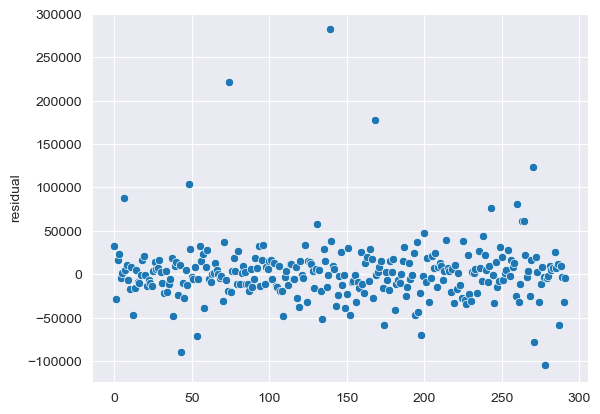

In [119]:
ax = sns.scatterplot(x=np.arange(len(test_y)), y=(test_y - pipe.predict(test_X))) 
ax.set_ylabel("residual");

In [120]:
# Log transfer of target 

mixed_df = data_df[ohe_features + te_features + num_features]
target = np.log(data_df["SalePrice"])

dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, test_size=0.2, random_state=42)

preprocess = make_column_transformer ((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown="ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown="value"), te_features),)

pipe = make_pipeline(preprocess, LinearRegression( ))
scores = cross_val_score( pipe, dev_X, dev_y, cv=10, error_score="raise")
print (scores)
print (f'The mean score of this model is:{np.mean(scores):0.3f}')

[0.8953829  0.83602114 0.8575512  0.77413971 0.49263465 0.86014109
 0.81150122 0.86437394 0.83683848 0.89544034]
The mean score of this model is:0.812


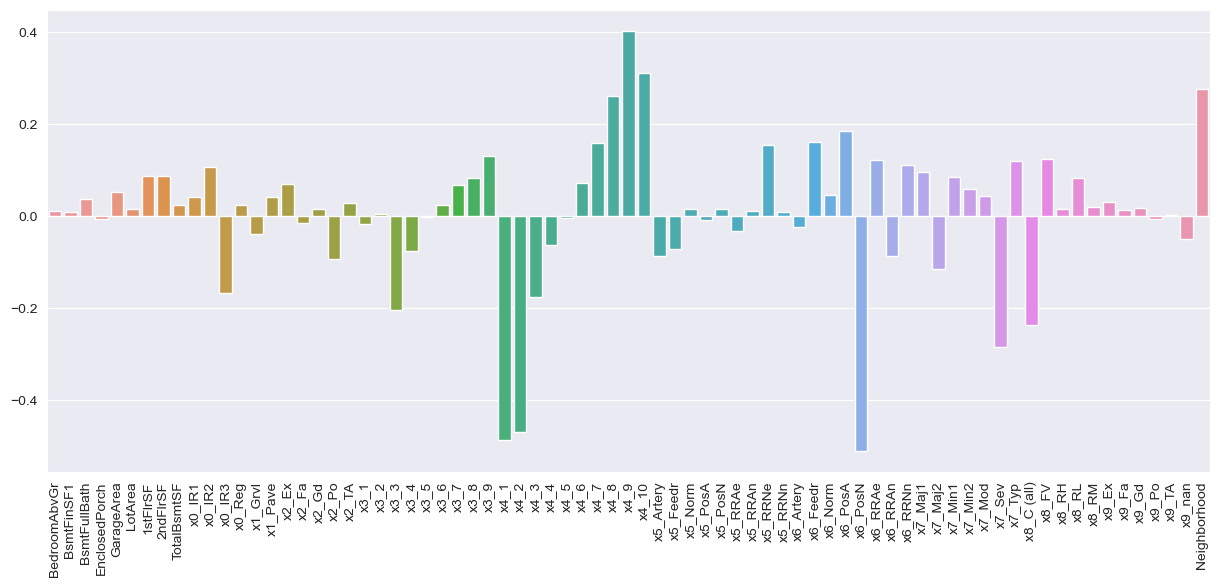

In [121]:
pipe.fit(dev_X, dev_y)
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
te_feature_names = preprocess.named_transformers_["targetencoder"].get_feature_names()
feature_names = num_features + ohe_feature_names + te_feature_names
coefs = pipe[-1].coef_
fig,ax = plt.subplots(1,1,figsize=(15,6))
ax = sns.barplot(x=feature_names, y=coefs)
ax.tick_params(axis='x', rotation=90)

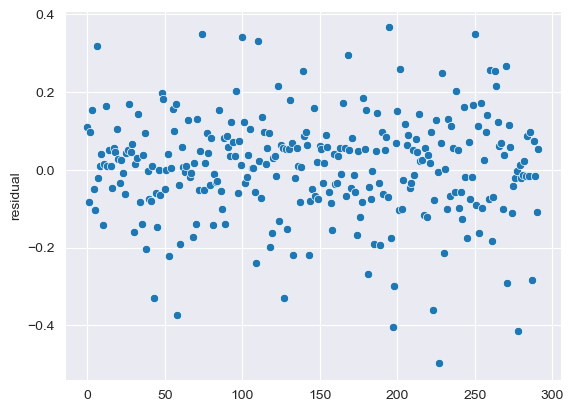

In [122]:
ax = sns.scatterplot(x=np.arange(len(test_y)),y=(test_y - pipe.predict(test_X))) 
ax.set_ylabel("residual");

# Ridge regression

In [41]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = data_df["SalePrice"]

dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, test_size=0.2, random_state=42)

preprocess = make_column_transformer ((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown="ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown="value"), te_features),)

pipe = make_pipeline(preprocess, Ridge())
scores = cross_val_score(pipe, dev_X, dev_y, cv=10, error_score="raise")
print (scores)
print (f'The mean score of this model is:{np.mean(scores):0.3f}')

[0.59057126 0.42352026 0.56964418 0.46857538 0.49791895 0.48956644
 0.5742154  0.50807332 0.42764345 0.58332401]
The mean score of this model is:0.513


In [44]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = np.log(data_df["SalePrice"])

dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, test_size=0.2, random_state=42)

preprocess = make_column_transformer ((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown="ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown="value"), te_features),)

pipe = make_pipeline(preprocess, Ridge())
scores = cross_val_score(pipe, dev_X, dev_y, cv=10, error_score="raise")
print (scores)
print (f'The mean score of this model is:{np.mean(scores):0.3f}')

[0.89456627 0.85149203 0.86694668 0.78474809 0.53149069 0.85614069
 0.85691176 0.86522013 0.8387113  0.89676099]
The mean score of this model is:0.824


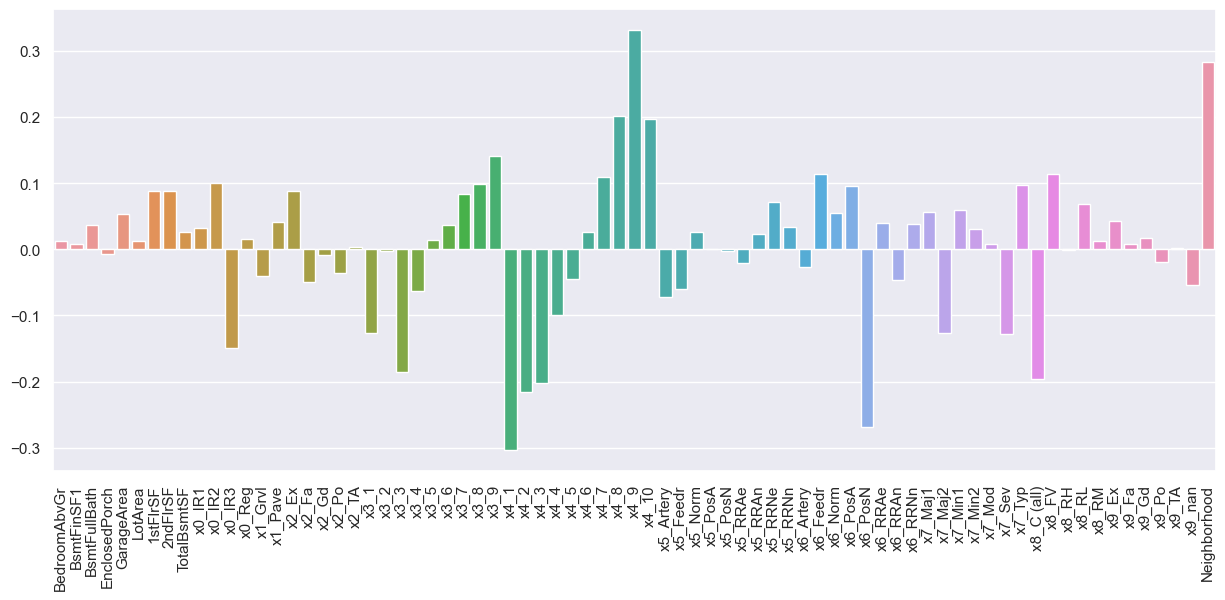

In [45]:
pipe.fit(dev_X, dev_y)
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
te_feature_names = preprocess.named_transformers_["targetencoder"].get_feature_names()
feature_names = num_features + ohe_feature_names + te_feature_names
coefs = pipe[-1].coef_
fig,ax = plt.subplots(1,1,figsize=(15,6))
ax = sns.barplot(x=feature_names, y=coefs)
ax.tick_params(axis='x', rotation=90)

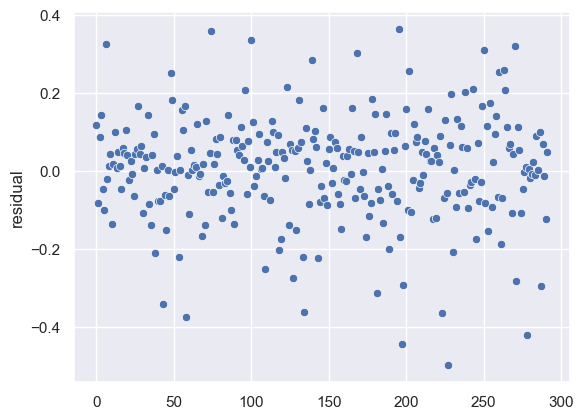

In [46]:
ax = sns.scatterplot(x=np.arange(len(test_y)),y=(test_y - pipe.predict(test_X))) 
ax.set_ylabel("residual");

# Ridge regression - hyperparameter tuning

In [47]:
preprocess = make_column_transformer ((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown="ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown="value"), te_features),)

pipe = make_pipeline(preprocess,
                     GridSearchCV(Ridge(),
                                  param_grid = [{"alpha":np.logspace(-3, 3, 10)}],
                                  return_train_score=True))

pipe.fit(mixed_df, target)
grid_search_results = pipe.named_steps["gridsearchcv"]
print (f"Best score:{grid_search_results.best_score_:0.3f}")
print (f"Best alpha:{grid_search_results.best_params_}")
print (f"Test score:{pipe.score(test_X, test_y):0.3f}")

Best score:0.848
Best alpha:{'alpha': 10.0}
Test score:0.911


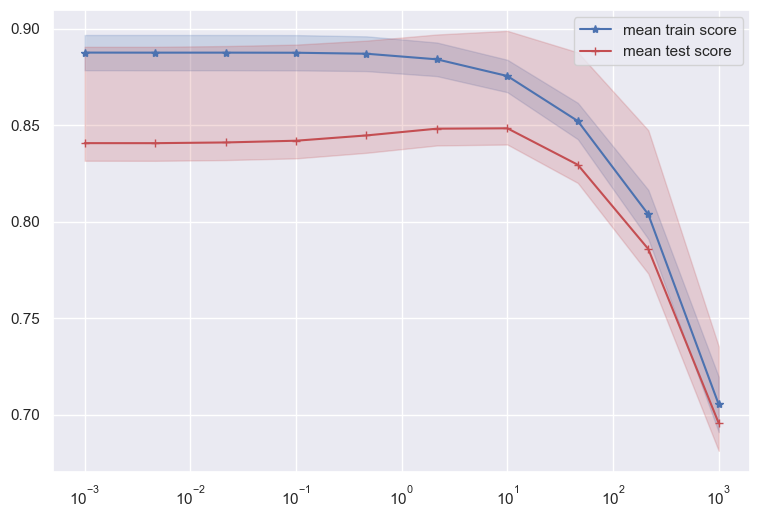

In [55]:
grid_search_results = pipe.named_steps["gridsearchcv"]
mean_test_score = grid_search_results.cv_results_["mean_test_score"]
std_test_score = grid_search_results.cv_results_["std_test_score"]
mean_train_score = grid_search_results.cv_results_["mean_train_score"]
std_train_score = grid_search_results.cv_results_["std_train_score"]
alpha_params = [d['alpha'] for d in grid_search_results.cv_results_["params"]]
sns.set( )
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(alpha_params, mean_train_score, 'b*-', label='mean train score')
plt.fill_between(alpha_params, mean_train_score - std_train_score,
                 mean_train_score + std_train_score, color='b', alpha=0.2)
plt.plot(alpha_params, mean_test_score, 'r+-', label='mean test score ' )
plt.fill_between(alpha_params, mean_test_score - std_train_score,
                 mean_test_score + std_test_score, color='r', alpha=0.2)
plt.legend()
ax.set_xscale('log')
plt.show()

# Lasso regression

In [59]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = np.log(data_df["SalePrice"])

dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, test_size=0.2, random_state=42)

preprocess = make_column_transformer ((StandardScaler(), num_features),
                                      (OneHotEncoder (handle_unknown="ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown="value"), te_features),)

pipe = make_pipeline(preprocess, Lasso(alpha=1.0))
scores = cross_val_score(pipe, dev_X, dev_y, cv=10, error_score="raise")
print (scores)
print (f'The mean score of this model is:{np.mean(scores):0.3f}')

[-1.51312578e-03 -3.49328192e-03 -2.93540165e-02 -3.56696218e-03
 -1.46702996e-02 -9.79493587e-03 -4.55509622e-03 -3.73018028e-04
 -9.57262546e-05 -7.04991496e-03]
The mean score of this model is:-0.007


In [60]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = np.log(data_df["SalePrice"])

dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, test_size=0.2, random_state=42)

preprocess = make_column_transformer ((StandardScaler(), num_features),
                                      (OneHotEncoder (handle_unknown="ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown="value"), te_features),)

pipe = make_pipeline(preprocess, Lasso(alpha=0.1))
scores = cross_val_score(pipe, dev_X, dev_y, cv=10, error_score="raise")
print (scores)
print (f'The mean score of this model is:{np.mean(scores):0.3f}')

[0.52802342 0.5065579  0.53182997 0.44564904 0.33896109 0.4322538
 0.48875767 0.48883398 0.43652834 0.49754664]
The mean score of this model is:0.469


In [110]:
mixed_df = data_df[ohe_features + te_features + num_features]
target = np.log(data_df["SalePrice"])

dev_X, test_X, dev_y, test_y = train_test_split(mixed_df, target, test_size=0.2, random_state=42)

preprocess = make_column_transformer ((StandardScaler(), num_features),
                                      (OneHotEncoder (handle_unknown="ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown="value"), te_features),)

pipe = make_pipeline(preprocess, Lasso(alpha=0.01))
scores = cross_val_score(pipe, dev_X, dev_y, cv=10, error_score="raise")
print (scores)
print (f'The mean score of this model is:{np.mean(scores):0.3f}')

[0.8366061  0.83438682 0.82532131 0.70633451 0.42958249 0.77676291
 0.820875   0.78605352 0.77910051 0.82373417]
The mean score of this model is:0.762


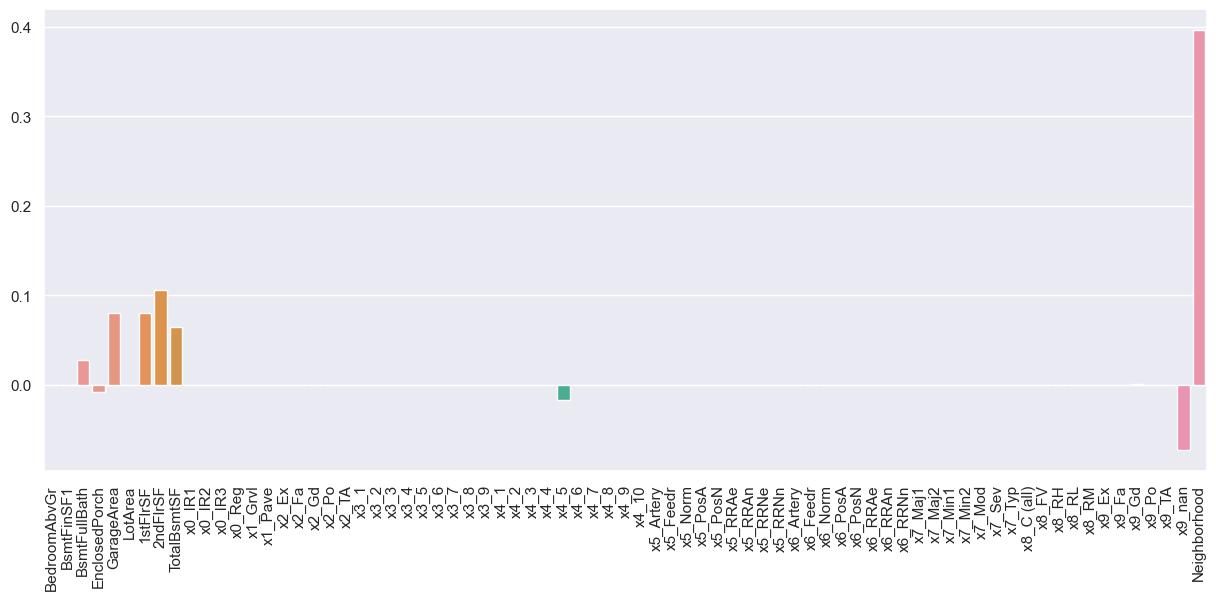

In [62]:
pipe.fit(dev_X, dev_y)
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
te_feature_names = preprocess.named_transformers_["targetencoder"].get_feature_names()
feature_names = num_features + ohe_feature_names + te_feature_names
coefs = pipe[-1].coef_
fig,ax = plt.subplots(1,1,figsize=(15,6))
ax = sns.barplot(x=feature_names, y=coefs)
ax.tick_params(axis='x', rotation=90)

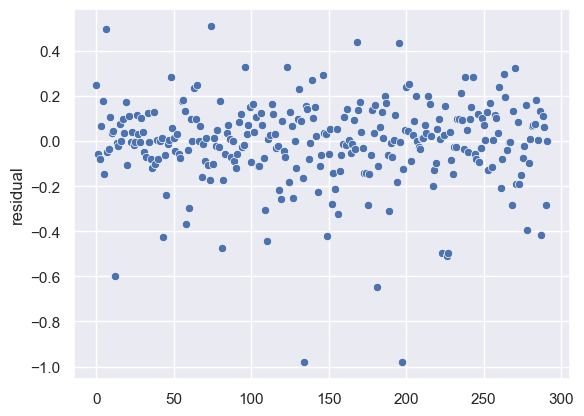

In [63]:
ax = sns.scatterplot(x=np.arange(len(test_y)),y=(test_y - pipe.predict(test_X))) 
ax.set_ylabel("residual");

# Lasso regression - hyperparameter tuning

In [67]:
preprocess = make_column_transformer ((StandardScaler(), num_features),
                                      (OneHotEncoder (handle_unknown="ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown="value"), te_features),)

pipe = make_pipeline(preprocess,
                     GridSearchCV(Lasso(),
                                  param_grid = [{"alpha":np.logspace(-4, 2, 30)}],
                                  return_train_score=True))
pipe.fit(mixed_df, target)
grid_search_results = pipe.named_steps["gridsearchcv"]
print (f"Best score:{grid_search_results.best_score_:0.3f}")
print (f"Best alpha:{grid_search_results.best_params_}")
print (f"Test score:{pipe.score(test_X, test_y):0.3f}")

Best score:0.849
Best alpha:{'alpha': 0.0006723357536499335}
Test score:0.912


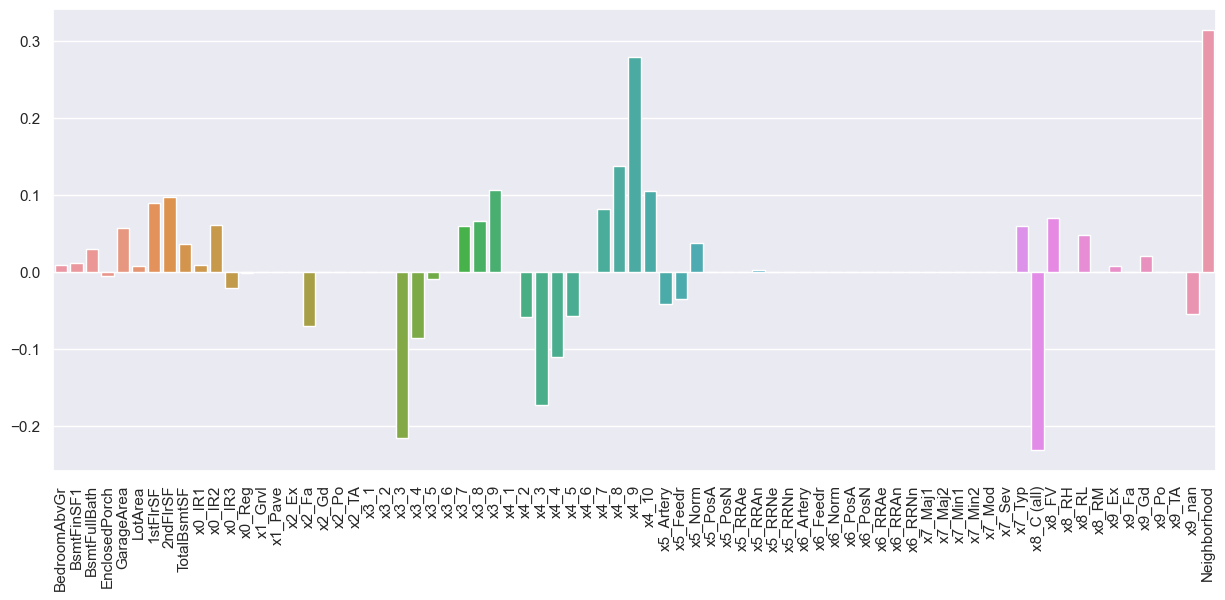

In [70]:
pipe.fit(mixed_df, target)
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
te_feature_names = preprocess.named_transformers_["targetencoder"].get_feature_names()
feature_names = num_features + ohe_feature_names + te_feature_names
coefs = pipe[-1].best_estimator_.coef_
fig,ax = plt.subplots(1,1,figsize=(15,6))
ax = sns.barplot(x=feature_names, y=coefs)
ax.tick_params(axis='x', rotation=90)

# Elastic-net regression - hyperparameter tuning

In [112]:
preprocess = make_column_transformer ((StandardScaler(), num_features),
                                      (OneHotEncoder (handle_unknown="ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown="value"), te_features),)

pipe = make_pipeline(preprocess,
                     GridSearchCV(ElasticNet(),
                                  param_grid = [{"alpha":np.logspace(-4, 2, 30),
                                                 "l1_ratio":np.logspace(-2, 0, 10)}],                                  
                                  return_train_score=True))
pipe.fit(mixed_df, target)
grid_search_results = pipe.named_steps["gridsearchcv"]
print (f"Best score:{grid_search_results.best_score_:0.3f}")
print (f"Best alpha:{grid_search_results.best_params_}")
print (f"Test score:{pipe.score(test_X, test_y):0.3f}")

Best score:0.851
Best alpha:{'alpha': 0.0028072162039411755, 'l1_ratio': 0.0774263682681127}
Test score:0.914


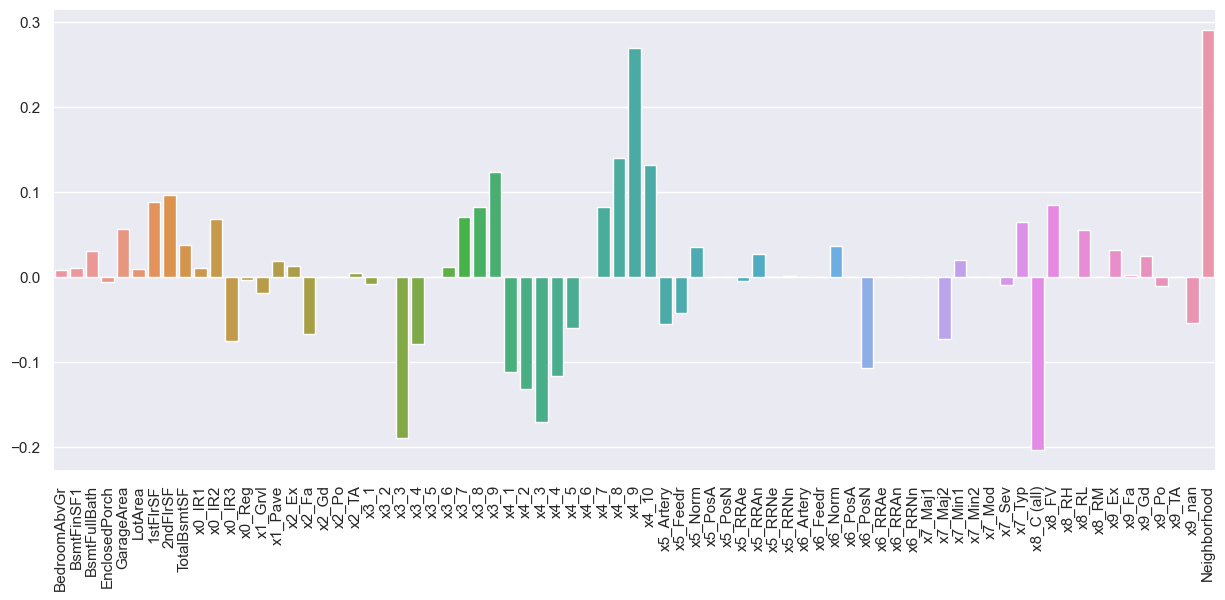

In [113]:
pipe.fit(mixed_df, target)
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
te_feature_names = preprocess.named_transformers_["targetencoder"].get_feature_names()
feature_names = num_features + ohe_feature_names + te_feature_names
coefs = pipe[-1].best_estimator_.coef_
fig,ax = plt.subplots(1,1,figsize=(15,6))
ax = sns.barplot(x=feature_names, y=coefs)
ax.tick_params(axis='x', rotation=90)